In [1]:
import os
from glob import glob
from tqdm import tqdm 

import numpy as np
import matplotlib.pyplot as plt 

import tifffile 
import json
import h5py

from PIL import Image
from scipy import ndimage

from tkinter import Tcl
#from random import shuffle

from sklearn.utils import shuffle

#from random import Random

from preProcessingUtils import *

In [2]:
root_dir = 'D:\sagar\Data'
scans = os.listdir(root_dir)

In [3]:
path_roi = []
path_notRoi = []

for s in scans:
    scan_path = os.path.join(root_dir, s)
    for r in os.listdir(os.path.join(scan_path, 'roi')):
        path_roi.append((os.path.join(root_dir, s, 'roi', r)))
    try:
        for nr in os.listdir(os.path.join(scan_path, 'not_roi')):
            path_notRoi.append((os.path.join(root_dir, s, 'not_roi', nr)))
    except:
        pass

print('Found ', len(path_roi), ' ROI and ', len(path_notRoi), ' notROI sample')         

Found  533  ROI and  561  notROI sample


In [4]:
# Shuffleing and choosing the sample for test and train 
path_roi = shuffle(path_roi, random_state=3)
path_notRoi = shuffle(path_notRoi, random_state=3)

In [5]:
train_roi_path, test_roi_path = path_roi[0:500], path_roi[500:533]
train_notRoi_path, test_notRoi_path = path_notRoi[0:500], path_notRoi[500:561]

In [6]:
def create_formatted_data(dataPath, xdim=300, ydim=300, zdim=300, resize_factor=(0.5, 0.5, 0.5)):
    
    print('Loading ', len(dataPath), ' Samples.... ')
    
    formattedData = np.empty(shape=(len(dataPath), int(xdim*resize_factor[0]), int(ydim*resize_factor[1]), int(zdim*resize_factor[2]), 1), dtype=np.float32)

    for i, afile in enumerate(tqdm(dataPath)):
        raw_vol = []
        #sorting the slices according to their names like in windows 
        slices = Tcl().call('lsort', '-dict', os.listdir(afile))
        for aSlice in slices:
            img = Image.open(os.path.join(afile, aSlice))
            imgarray = np.array(img)
            raw_vol.append(imgarray)

        raw_vol = np.asarray(raw_vol)
        raw_vol = np.nan_to_num(raw_vol)
        # Normalize the data : 0-1
        vol = norm(raw_vol)
        formattedData[i, :, :, :, 0] = ndimage.zoom(vol, resize_factor, order=1)
    
    print('Loaded ', len(dataPath), ' Samples with shape ', formattedData.shape, '\n')
    return formattedData
    

In [8]:
train_roi = create_formatted_data(train_roi_path)
test_roi = create_formatted_data(test_roi_path)


Loading  500  Samples.... 


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [07:05<00:00,  1.17it/s]


Loaded  500  Samples with shape  (500, 150, 150, 150, 1) 

Loading  33  Samples.... 


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]

Loaded  33  Samples with shape  (33, 150, 150, 150, 1) 



In [9]:
train_notRoi = create_formatted_data(train_notRoi_path)
test_notRoi = create_formatted_data(test_notRoi_path)

Loading  500  Samples.... 


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [17:57<00:00,  2.16s/it]


Loaded  500  Samples with shape  (500, 150, 150, 150, 1) 

Loading  61  Samples.... 


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [01:21<00:00,  1.33s/it]

Loaded  61  Samples with shape  (61, 150, 150, 150, 1) 



In [10]:
# Creating the label 
train_roi_label = []
for i in range(len(train_roi_path)):
    train_roi_label.append([1, 0])

train_roi_label = np.array(train_roi_label)


# Creating the label 
train_notRoi_label = []
for i in range(len(train_notRoi_path)):
    train_notRoi_label.append([0, 1])

train_notRoi_label = np.array(train_notRoi_label)


# Creating the label 
test_roi_label = []
for i in range(len(test_roi_path)):
    test_roi_label.append([1, 0])

test_roi_label = np.array(test_roi_label)


# Creating the label 
test_notRoi_label = []
for i in range(len(test_notRoi_path)):
    test_notRoi_label.append([0, 1])

test_notRoi_label = np.array(test_notRoi_label)

In [11]:
hf = h5py.File('Norm_150_150_150_Train.hdf5', 'w')
hf.create_dataset('roi', data=train_roi, compression='gzip')
hf.create_dataset('notRoi', data=train_notRoi, compression='gzip')
hf.close()

In [12]:
hf = h5py.File('Norm_150_150_150_Test.hdf5', 'w')
hf.create_dataset('roi', data=test_roi, compression='gzip')
hf.create_dataset('notRoi', data=test_notRoi, compression='gzip')
hf.close()

In [13]:
hf = h5py.File('Train_Label.hdf5', 'w')
hf.create_dataset('roi', data=train_roi_label, compression='gzip')
hf.create_dataset('notRoi', data=train_notRoi_label, compression='gzip')
hf.close()

In [14]:
hf = h5py.File('Test_Label.hdf5', 'w')
hf.create_dataset('roi', data=test_roi_label, compression='gzip')
hf.create_dataset('notRoi', data=test_notRoi_label, compression='gzip')
hf.close()

In [ ]:
# Data Augmentation : 8 Set Possible
# 1. Original Data 
# 2,3,4,5 Rotate 45, 90, 180 
# 6, 7, 8 Flip  

In [15]:

aVol = train_roi[0, :, :, :, 0]

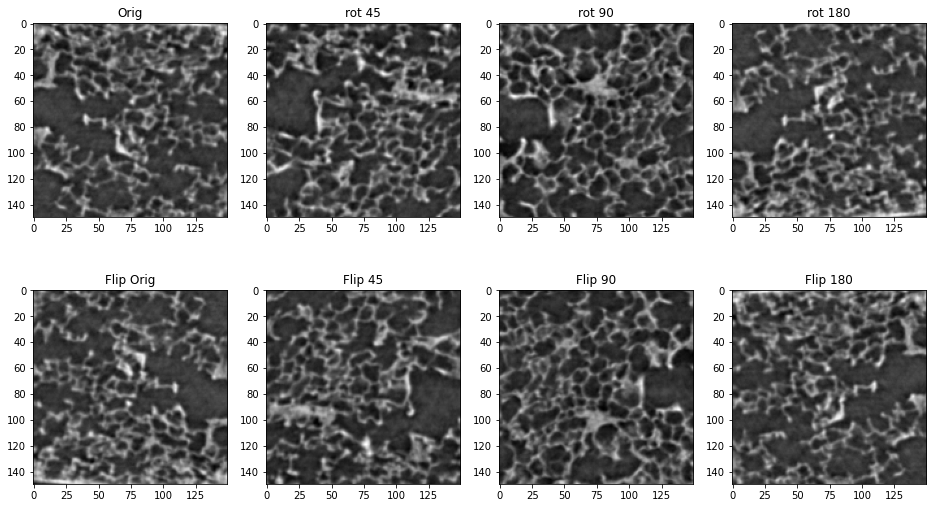

In [48]:
fig, ax = plt.subplots(2,4, figsize=(16,9))
ax[0,0].imshow(aVol[75, :, :,], cmap='gray')
ax[0,0].set_title('Orig')

rot45 = ndimage.rotate(aVol, 45, reshape=False)
ax[0,1].imshow(rot45[75, :, :], cmap='gray')
ax[0,1].set_title('rot 45')

rot90 = ndimage.rotate(aVol, 90, reshape=False)
ax[0,2].imshow(rot90[75, :, :], cmap='gray')
ax[0,2].set_title('rot 90')

rot180 = ndimage.rotate(aVol, 180, reshape=False)
ax[0,3].imshow(rot180[75, :, :], cmap='gray')
ax[0,3].set_title('rot 180')

###########

flip = np.flip(aVol)
ax[1,0].imshow(flip[75, :, :], cmap='gray')
ax[1,0].set_title('Flip Orig')


flip45 = np.flip(rot45)
ax[1,1].imshow(flip45[75, :, :], cmap='gray')
ax[1,1].set_title('Flip 45')

flip90 = np.flip(rot90)
ax[1,2].imshow(flip90[75, :, :], cmap='gray')
ax[1,2].set_title('Flip 90')

flip180 = np.flip(rot180)
ax[1,3].imshow(flip180[75, :, :], cmap='gray')
ax[1,3].set_title('Flip 180')

plt.show()

plt.close()

In [53]:
# Rotate formatted volume 
def rotateFormattedVol(arr, angle, reshape=False):
    result = np.empty_like(arr)
    for i in range(arr.shape[0]):
        vol = arr[i, :, :, :, 0]
        vol = ndimage.rotate(vol, angle, reshape=reshape)
        vol[ vol < 0] = 0
        vol[ vol > 1] = 1
        result[i, :, :, :, 0] = vol 
        
    return result


# Flip formatted volume 
def flipFormattedVol(arr):
    result = np.empty_like(arr)
    for i in range(arr.shape[0]):
        vol = arr[i, :, :, :, 0]
        vol = np.flip(vol)
        result[i, :, :, :, 0] = vol 
    
    return result
    

In [50]:
train_roi.shape

(500, 150, 150, 150, 1)

In [54]:
trainDataROI = np.concatenate( (train_roi, flipFormattedVol(train_roi), 
                                rotateFormattedVol(train_roi, 45), flipFormattedVol(rotateFormattedVol(train_roi, 45)), 
                                rotateFormattedVol(train_roi, 90), flipFormattedVol(rotateFormattedVol(train_roi, 90)), 
                                rotateFormattedVol(train_roi, 180), flipFormattedVol(rotateFormattedVol(train_roi, 180))),
                                axis=0)

train_label_ROI = np.concatenate((train_roi_label, train_roi_label,
                                  train_roi_label, train_roi_label,
                                  train_roi_label, train_roi_label,
                                  train_roi_label, train_roi_label), axis=0)

In [56]:
train_label_ROI.shape

(4000, 2)

In [58]:
trainDatanotROI = np.concatenate( (train_notRoi, flipFormattedVol(train_notRoi), 
                                rotateFormattedVol(train_notRoi, 45), flipFormattedVol(rotateFormattedVol(train_notRoi, 45)), 
                                rotateFormattedVol(train_notRoi, 90), flipFormattedVol(rotateFormattedVol(train_notRoi, 90)), 
                                rotateFormattedVol(train_notRoi, 180), flipFormattedVol(rotateFormattedVol(train_notRoi, 180))),
                                axis=0)

train_label_notROI = np.concatenate((train_notRoi_label, train_notRoi_label,
                                  train_notRoi_label, train_notRoi_label,
                                  train_notRoi_label, train_notRoi_label,
                                  train_notRoi_label, train_notRoi_label), axis=0)

In [59]:
%whos

Variable                Type        Data/Info
---------------------------------------------
Image                   module      <module 'PIL.Image' from <...>packages\\PIL\\Image.py'>
Tcl                     function    <function Tcl at 0x000002061F42E700>
aVol                    ndarray     150x150x150: 3375000 elems, type `float32`, 13500000 bytes (12.874603271484375 Mb)
ax                      ndarray     2x4: 8 elems, type `object`, 64 bytes
create_formatted_data   function    <function create_formatte<...>ta at 0x0000020620BD0160>
ctypes                  module      <module 'ctypes' from 'C:<...>ib\\ctypes\\__init__.py'>
fig                     Figure      Figure(1152x648)
flip                    ndarray     150x150x150: 3375000 elems, type `float32`, 13500000 bytes (12.874603271484375 Mb)
flip135                 ndarray     150x150x150: 3375000 elems, type `float32`, 13500000 bytes (12.874603271484375 Mb)
flip180                 ndarray     150x150x150: 3375000 elems, type `float

In [60]:
hf = h5py.File('E:\\sagar\\Data\\TrainData.hdf5', 'w')
hf.create_dataset('roi', data=trainDataROI, compression='gzip')
hf.create_dataset('notRoi', data=trainDatanotROI, compression='gzip')
hf.close()

In [61]:
hf = h5py.File('E:\\sagar\\Data\\TrainLabel.hdf5', 'w')
hf.create_dataset('roi', data=train_label_ROI, compression='gzip')
hf.create_dataset('notRoi', data=train_label_notROI, compression='gzip')
hf.close()

In [62]:
import gc

In [65]:
gc.collect()

0